# Quality of clusterings

We compare the returned clusterings of *spectral clustering*, the *Louvain method* and *label propagation* on a [stochastic block model.](https://en.wikipedia.org/wiki/Stochastic_block_model) For the comparison we use two clustering metrics, the Rand index / distance and variation of information. 

In [1]:
import networkx as nx 
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import math
import scipy
import numpy as np
from collections import Counter

To visualise the adjacency matrix, we re-use code from a notebook on the chip placement problem, see [GitHub](https://github.com/henningbruhn/gtds/blob/main/placement.ipynb) or [Colab](https://colab.research.google.com/github/henningbruhn/gtds/blob/main/placement.ipynb).

In [2]:
def right(old_size,new_size):
    num_rows=old_size
    num_cols=new_size
    mult=math.ceil(num_rows/num_cols)
    cols=[i for i in range(num_cols) for j in range(mult)][:num_rows]
    rows=range(num_rows)
    data=np.ones(num_rows)
    R=scipy.sparse.coo_matrix((data,(rows,cols)))
    return R

def left(old_size,new_size):
    return right(old_size,new_size).T

def reduce(matrix,new_size):
    # we assume a square matrix
    old_size=matrix.shape[0]
    scale_factor=old_size/new_size
    return (left(old_size,new_size)@matrix@right(old_size,new_size) / (scale_factor**2)).todense()

def spy(matrix,new_size=1000,scale_factor=1,ax=None,figdim=4):
    reduced_matrix=reduce(matrix,new_size)
    if ax is None:
        fig,ax=plt.subplots(figsize=(figdim,figdim))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(reduced_matrix*scale_factor,cmap='binary',vmin=0,vmax=1)
    return ax

def adjacency_matrix_by_clusters(G,clusters):
    """reorder adjacency matrix so that clusters are consecutive"""
    node_mapper={name:i for i,name in enumerate(G.nodes)}  # maps node names to row/column index in adjacency matrix
    new_order=[node_mapper[name] for cluster in clusters for name in cluster]
    A=nx.adjacency_matrix(G)
    reordered=((A[new_order]).T[new_order]).T
    return reordered

We will judge the quality of the returned clusterings with the help of two metrics on the space of all clusterings of the vertex set. See this notebook: [GitHub link](https://github.com/henningbruhn/gtds/blob/main/comparing.ipynb) or [Colab link](https://colab.research.google.com/github/henningbruhn/gtds/blob/main/comparing.ipynb)

In [3]:
### Rand distance ###
def sum_choose_2(sizes):
    return sum([size*(size-1)/2 for size in sizes])

def rand(A,B):
    """we assume the clusterings A,B to be encoded as lists 
    s.t. if entry i is k then the ith element of the ground set is in cluster k"""
    sizes_AB=Counter(zip(A,B))
    sizes_A=Counter(A)
    sizes_B=Counter(B)
    factor=2/(len(A)*(len(A)-1))
    return (sum_choose_2(sizes_A.values())+sum_choose_2(sizes_B.values())-2*sum_choose_2(sizes_AB.values()))*factor

### variation of information ###
def safe_xlogx(x):
    if x==0:
        return 0
    return x*math.log(x,2)

def joint_entropy(A,B):
    return entropy(list(zip(A,B)))

def entropy(A):
    sizes_A=Counter(A)
    n=len(A)
    # not optimised for speed -- would be faster if implemented with numpy.where
    return -sum([safe_xlogx(size/n) for size in sizes_A.values()])

def VI(A,B):
    return 2*joint_entropy(A,B)-entropy(A)-entropy(B)

## The test instance

Next, we generate our distance instance, a stochastic block model. We set up 10 clusters of size 50 vertices each, with an edge probability within the clusters of $p=0.3$ and an edge probability between clusters of $p=0.1$. To exclude that the algorithms can use the order of the vertices in any way (perhaps because in some step the vertices are processed in order), we randomly permute the vertices. We visualise the adjacency matrix before and after permuting.

Text(0.5, 1.0, 'adjacency matrix, random order')

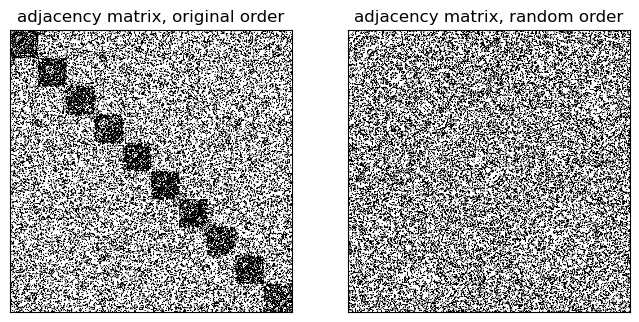

In [4]:
def get_sbm(cluster_size,num_clusters,intra_prob,inter_prob):
    sizes=[cluster_size]*num_clusters
    probs=np.ones((num_clusters,num_clusters))*inter_prob+np.diag([intra_prob-inter_prob]*num_clusters)    
    return nx.stochastic_block_model(sizes, probs)

cluster_size=50
num_clusters=10
intra_prob=0.3
inter_prob=0.1
G=get_sbm(cluster_size,num_clusters,intra_prob,inter_prob)
n=G.number_of_nodes()
rnd_order=np.random.permutation(range(n))
A=nx.adjacency_matrix(G)
reordered=((A[rnd_order]).T[rnd_order]).T
H=nx.from_scipy_sparse_array(reordered)

fig,axs=plt.subplots(1,2,figsize=(8,4))
spy(nx.adjacency_matrix(G),scale_factor=1,ax=axs[0])
axs[0].set_title("adjacency matrix, original order")
spy(nx.adjacency_matrix(H),scale_factor=1,ax=axs[1])
axs[1].set_title("adjacency matrix, random order")

That's good, the clusters are not visible any more (but still there!). Later on, we will compare the computed clusters to the ground truth clusters, ie, the clusters of the stochastic block model. As we've permuted the vertices, we need to figure out what the new names of the vertices in the 10 ground truth clusters are. To this end, we need to compute the inverse permutation. To check that we've not made a mistake we plot the adjacency matrix with the vertices order according to the ground truth clusters.

<Axes: >

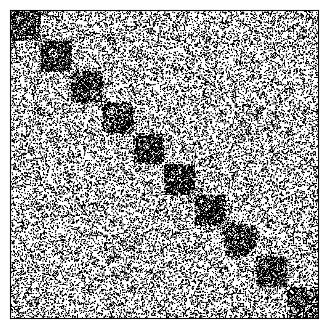

In [5]:
inverse= [i for el,i in sorted([(el,i) for i,el in enumerate(rnd_order)])]
sizes=[cluster_size]*num_clusters
indices=np.cumsum([0]+sizes)
ground_truth_clusters=[inverse[indices[i]:indices[i]+s] for i,s in enumerate(sizes)]
spy(adjacency_matrix_by_clusters(H,ground_truth_clusters),scale_factor=1)

Wonderful. Next, let's set up two convenience methods: One to compute the intersection matrix $|A\cap B|$, $A\in\mathcal A$ and $B\in\mathcal B$, for two clusterings $\mathcal A$ and $\mathcal B$, and one method to spit out rudimentary statistics about a clustering.  

In [6]:
def compute_intersections(AA,BB):
    return [[len(set(A).intersection(B)) for B in BB] for A in AA]

def cluster_stats(clusters):
    num_clusters=len(clusters)
    sizes=[len(cluster) for cluster in clusters]
    print("{} clusters".format(num_clusters))
    print("sizes: {}".format(sizes))

## The clustering algorithms

We start clustering. First, we do spectral clustering. Spectral clustering will enjoy a quite big advantage: We need to specify the number of clusters beforehand, and we will input the correct number of clusters, ie, 10. 

<code>SpectralClustering</code> of *sci-kit learn* returns a list $[0,0,1,2,0,...]$ with one entry per vertex such that the entry designates the cluster number of the vertex. We will also need the clusters as a list of vertex indices.

In [7]:
from sklearn.cluster import SpectralClustering
n_clusters=10
sc=SpectralClustering(n_clusters=n_clusters,affinity="precomputed")
spec_array=sc.fit_predict(nx.adjacency_matrix(H).todense())
spec_clusters=[[i for i,cluster_num in enumerate(spec_array) if cluster_num==c] for c in range(n_clusters)]

cluster_stats(spec_clusters)

10 clusters
sizes: [43, 45, 51, 51, 58, 44, 52, 59, 49, 48]


Aha. That looks already fairly close to the ground truth. Let's have a detailed look by verifying the intersections.

In [8]:
compute_intersections(ground_truth_clusters,spec_clusters)

[[0, 0, 1, 0, 8, 1, 0, 0, 39, 1],
 [41, 0, 0, 0, 1, 0, 1, 4, 1, 2],
 [0, 1, 1, 2, 0, 0, 44, 0, 1, 1],
 [1, 0, 0, 0, 6, 2, 0, 0, 4, 37],
 [0, 40, 0, 2, 1, 1, 2, 3, 0, 1],
 [0, 0, 0, 46, 0, 0, 1, 0, 2, 1],
 [1, 1, 43, 1, 2, 0, 0, 1, 0, 1],
 [0, 2, 2, 0, 1, 0, 2, 42, 0, 1],
 [0, 1, 2, 0, 1, 40, 1, 3, 1, 1],
 [0, 0, 2, 0, 38, 0, 1, 6, 1, 2]]

Quite close. Next, we apply the *Louvain method*. 

7 clusters
sizes: [68, 52, 52, 100, 57, 111, 60]


<Axes: >

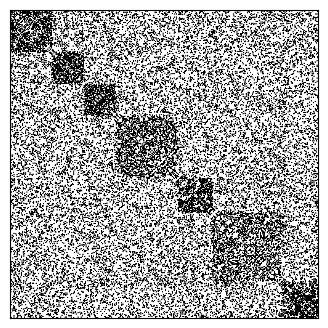

In [9]:
louvain_clusters=list(nx.community.louvain_communities(H))
cluster_stats(louvain_clusters)
spy(adjacency_matrix_by_clusters(H,louvain_clusters),scale_factor=1)

Okay, we did not get quite the right number of clusters. Let's have a closer look.

In [10]:
compute_intersections(ground_truth_clusters,louvain_clusters)

[[7, 0, 4, 9, 0, 23, 7],
 [1, 0, 0, 44, 1, 2, 2],
 [1, 47, 0, 0, 0, 1, 1],
 [0, 0, 0, 1, 2, 46, 1],
 [0, 0, 44, 1, 1, 2, 2],
 [2, 2, 0, 44, 0, 2, 0],
 [46, 2, 0, 0, 1, 1, 0],
 [0, 1, 0, 0, 47, 2, 0],
 [2, 0, 1, 0, 1, 0, 46],
 [9, 0, 3, 1, 4, 32, 1]]

Some of the ground truth clusters are distributed over a number of found clusters. Some are lumped together with parts of other clusters. 

Finally, we do label propagation.

In [11]:
lpa_clusters=list(nx.community.asyn_lpa_communities(H))
cluster_stats(lpa_clusters)

1 clusters
sizes: [500]


Huh. That's bad. 

Visually, we see that spectral clustering gives the best clustering, followed by the Louvain method, and label propagation, with its all-in-one bag clustering is dead last. Let's see whether Rand distance and variation of information confirm these results. To do so, we need to compute arrays that indicate for each element the cluster number. (This is not necessary for spectral clustering as the output is already in that form.) 

In [12]:
def list_to_array(cluster_list):
    n=sum([len(cluster) for cluster in cluster_list])
    cluster_array=np.zeros(n)
    for cluster_num,cluster in enumerate(cluster_list):
        cluster_array[list(cluster)]=cluster_num
    return cluster_array

ground_truth_array=list_to_array(ground_truth_clusters)
lpa_array=list_to_array(lpa_clusters)
louvain_array=list_to_array(louvain_clusters)

First, we compute the Rand distances to the ground truth.

In [13]:
r_spec,r_louvain,r_lpa=rand(spec_array,ground_truth_array),rand(louvain_array,ground_truth_array),rand(lpa_array,ground_truth_array)
print("Rand spectral  : {:.3f}".format(r_spec))
print("Rand Louvain   : {:.3f}".format(r_louvain))
print("Rand label prop: {:.3f}".format(r_lpa))

Rand spectral  : 0.064
Rand Louvain   : 0.109
Rand label prop: 0.902


This confirms our intutive findings. Next, we compute the variation of information.

In [14]:
vi_spec,vi_louvain,vi_lpa=VI(spec_array,ground_truth_array),VI(louvain_array,ground_truth_array),VI(lpa_array,ground_truth_array)
print("VI spectral  : {:.3f}".format(vi_spec))
print("VI Louvain   : {:.3f}".format(vi_louvain))
print("VI label prop: {:.3f}".format(vi_lpa))

VI spectral  : 2.078
VI Louvain   : 2.236
VI label prop: 3.322


Again, we get the same order. However, if you re-run this notebook or if you play around with the probabilities you may get results that differ significantly. 